In [1]:
import h5py
import pylab as pl
import numpy as np
#import matplotlib as mpl
import networkx
import healpy as hp
import ipyvolume as ipv

In [2]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')

In [3]:
fofID = 32
OffSets = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
OffSets

array([444372, 497993])

In [4]:
PosGas = sim['SnapNumber_128/PartType0/Coordinates'][OffSets[0]:OffSets[1]]
SFRGas = sim['SnapNumber_128/PartType0/StarFormationRate'][OffSets[0]:OffSets[1]]
MassGas = sim['SnapNumber_128/PartType0/Masses'][OffSets[0]:OffSets[1]]

In [5]:
#and heal the pix of this thingy
nside = 8 # to much?, to little? lets find out
npix = hp.nside2npix(nside)

In [6]:
cen = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
x, y, z = PosGas[:,0]-cen[0], PosGas[:,1]-cen[1], PosGas[:,2]-cen[2]

pix = hp.pixelfunc.vec2pix(nside, x, y, z)

In [7]:
# and the delta_SFR, the global one is easy 
SFRtot = np.sum(MassGas*SFRGas)/np.sum(MassGas)

# the other ones, well ... 

x0, y0, z0 = hp.pixelfunc.pix2vec(nside, int(npix/2))
index = hp.query_disc(nside, (x0, y0, z0), np.pi/2.) # one half of pixels

index_bool = np.in1d(pix, index)
index_onehalf = np.where(index_bool)[0]
index_otherhalf = np.where(index_bool==False)[0]

In [8]:
Coor1 = PosGas[index_onehalf]
Coor2 = PosGas[index_otherhalf]

x1, y1, z1 = x[index_onehalf], y[index_onehalf], z[index_onehalf]
x2, y2, z2 = x[index_otherhalf], y[index_otherhalf], z[index_otherhalf]

fig = ipv.figure(width=750, height=750)

scatter1 = ipv.scatter(x1, y1, z1, marker='sphere', size=.5, color='blue')
scatter2 = ipv.scatter(x2, y2, z2, marker='sphere', size=.5, color='red')

ipv.show()

In [9]:
# lets calculate the anisotropy

SFR_onehalf, Mass_onehalf = SFRGas[index_onehalf], MassGas[index_onehalf]
SFR_otherhalf, Mass_otherhalf = SFRGas[index_otherhalf], MassGas[index_otherhalf]

SFR_one = np.sum(SFR_onehalf*Mass_onehalf)/np.sum(Mass_onehalf)
SFR_other = np.sum(SFR_otherhalf*Mass_otherhalf)/np.sum(Mass_otherhalf)

delta_SFR = (SFR_one - SFR_other)/SFRtot
delta_SFR

1.8893192

In [10]:
# and that's ... a number, it its to high?
SFR_one, SFR_other, SFRtot

(2.8013994e-05, 7.447642e-07, 1.44333635e-05)

In [11]:
np.sum(SFR_onehalf), np.sum(SFR_otherhalf), np.sum(SFRGas)

(0.76933485, 0.019259244, 0.7885942)

In [12]:
np.where(SFRGas==0)[0].size, np.where(SFRGas!=0)[0].size, 

(53148, 473)

In [13]:
# and iterate over half the pixels to find the vector of the greatest difference, positive or negative, then I see which is which

MaxDif = 0
vecMax = 0

for i in index:
    x0, y0, z0 = hp.pixelfunc.pix2vec(nside, i) # centre of the vector to test
    ind0 = hp.query_disc(nside, (x0, y0, z0), np.pi/2.) # one half of pixels

    index_bool = np.in1d(pix, ind0)
    index_onehalf = np.where(index_bool)[0]
    index_otherhalf = np.where(index_bool==False)[0]
    
    SFR_onehalf, Mass_onehalf = SFRGas[index_onehalf], MassGas[index_onehalf]
    SFR_otherhalf, Mass_otherhalf = SFRGas[index_otherhalf], MassGas[index_otherhalf]

    SFR_one = np.sum(SFR_onehalf*Mass_onehalf)/np.sum(Mass_onehalf)
    SFR_other = np.sum(SFR_otherhalf*Mass_otherhalf)/np.sum(Mass_otherhalf)

    delta_SFR = (SFR_one - SFR_other)/SFRtot
    
    if np.abs(delta_SFR) > MaxDif:
        MaxDif = delta_SFR
        if delta_SFR > 0:
            vecMax = np.array([x0, y0, z0])
        else:
            vecMax = np.array([-x0, -y0, -z0])

In [14]:
MaxDif, vecMax

(-1.9421653, array([0.07207475, 0.07207475, 0.99479167]))

In [15]:
# lets take a look at this.

index = hp.query_disc(nside, vecMax, np.pi/2.) # one half of pixels

index_bool = np.in1d(pix, index)
index_onehalf = np.where(index_bool)[0]
index_otherhalf = np.where(index_bool==False)[0]

x1, y1, z1 = x[index_onehalf], y[index_onehalf], z[index_onehalf]
x2, y2, z2 = x[index_otherhalf], y[index_otherhalf], z[index_otherhalf]

fig = ipv.figure(width=750, height=750)

scatter1 = ipv.scatter(x1, y1, z1, marker='sphere', size=.5, color='blue')
scatter2 = ipv.scatter(x2, y2, z2, marker='sphere', size=.5, color='red')

ipv.show()

In [16]:
npix

768

In [17]:
# ok, lets do this in secuence, if possible (ok, it this, I mean, for the ones that this thing works)
nside = 8
npix = hp.nside2npix(nside)
x0, y0, z0 = hp.pixelfunc.pix2vec(nside, 0)
index = hp.query_disc(nside, (x0, y0, z0), np.pi/2.)


def get_BetterVector(fofID):
    """
    return the vector parallel to the better half (points in the direction where the SFR is larger)
    """
    OffSets = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    if OffSets[0]<0 or OffSets[1]<0: # no gas particles
        return np.array([0,0,0]), 0.
    
    PosGas = sim['SnapNumber_128/PartType0/Coordinates'][OffSets[0]:OffSets[1]]
    SFRGas = sim['SnapNumber_128/PartType0/StarFormationRate'][OffSets[0]:OffSets[1]]
    MassGas = sim['SnapNumber_128/PartType0/Masses'][OffSets[0]:OffSets[1]]
    
    cen = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    x, y, z = PosGas[:,0]-cen[0], PosGas[:,1]-cen[1], PosGas[:,2]-cen[2]

    pix = hp.pixelfunc.vec2pix(nside, x, y, z)
    SFRtot = np.sum(MassGas*SFRGas)/np.sum(MassGas)
    
    MaxDif = 0
    vecMax = np.array([0,0,0])
    
    for i in index:
        x0, y0, z0 = hp.pixelfunc.pix2vec(nside, i) # centre of the vector to test
        
        ind0 = hp.query_disc(nside, (x0, y0, z0), np.pi/2.) # one half of pixels

        index_bool = np.in1d(pix, ind0)
        index_onehalf = np.where(index_bool)[0]
        index_otherhalf = np.where(index_bool==False)[0]
    
        SFR_onehalf, Mass_onehalf = SFRGas[index_onehalf], MassGas[index_onehalf]
        SFR_otherhalf, Mass_otherhalf = SFRGas[index_otherhalf], MassGas[index_otherhalf]

        SFR_one = np.sum(SFR_onehalf*Mass_onehalf)/np.sum(Mass_onehalf)
        SFR_other = np.sum(SFR_otherhalf*Mass_otherhalf)/np.sum(Mass_otherhalf)

        delta_SFR = (SFR_one - SFR_other)/SFRtot
    
        if np.abs(delta_SFR) > MaxDif:
            MaxDif = np.abs(delta_SFR)
            if delta_SFR > 0:
                vecMax = np.array([x0, y0, z0])
            else:
                vecMax = np.array([-x0, -y0, -z0])
    
    return vecMax, MaxDif

In [18]:
# read the thingy
SatFile = h5py.File('SatelliteList_V2.h5', 'r')

Satellites, Centrals = SatFile['SatelliteList'], SatFile['SatelliteCentral']

In [19]:
import progressbar

In [20]:
size = Satellites.size

bar = progressbar.ProgressBar(max_value=size)
C = 0

BetterVec, SatS, CenS, maxD = [], [], [], []

for Sa, Ce in zip(Satellites, Centrals):
    vecM, MD = get_BetterVector(Sa)
    if vecM[0]!=0 and vecM[1]!=0 and vecM[2]!=0:
        BetterVec.append(vecM)
        maxD.append(MD)
        SatS.append(Sa)
        CenS.append(Ce)
    bar.update(C)
    C += 1
    
BetterVec, SatS, CenS, maxD = np.array(BetterVec), np.array(SatS), np.array(CenS), np.array(maxD) 

<ipython-input-17-e646f9bb4e82>:44: RuntimeWarning: invalid value encountered in float_scalars
  delta_SFR = (SFR_one - SFR_other)/SFRtot
 14% (151 of 1012) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:05<ipython-input-17-e646f9bb4e82>:42: RuntimeWarning: invalid value encountered in float_scalars
  SFR_other = np.sum(SFR_otherhalf*Mass_otherhalf)/np.sum(Mass_otherhalf)
<ipython-input-17-e646f9bb4e82>:41: RuntimeWarning: invalid value encountered in float_scalars
  SFR_one = np.sum(SFR_onehalf*Mass_onehalf)/np.sum(Mass_onehalf)
 20% (205 of 1012) |####                 | Elapsed Time: 0:00:01 ETA:   0:00:05/home/srodriguez/miniconda3/envs/cielo_tutorial/lib/python3.8/site-packages/healpy/pixelfunc.py:655: RuntimeWarning: divide by zero encountered in _vec2pix_ring
  return pixlib._vec2pix_ring(nside, x, y, z)
/home/srodriguez/miniconda3/envs/cielo_tutorial/lib/python3.8/site-packages/healpy/pixelfunc.py:655: RuntimeWarning: invalid value encountered in _vec2pix_ring
  retur

In [21]:
SatS.size

20

In [22]:
with h5py.File('BetterVectorList_V2.h5', 'w') as f:
    f.create_dataset('SatelliteList', data=SatS)
    f.create_dataset('SatelliteCentral', data=CenS)
    f.create_dataset('BetterVectors', data=BetterVec)
    f.create_dataset('MaxDeltaSFR', data=maxD)

In [23]:
CosBV_C, CosBV_V = [], []
posC, velG = [], []

for Sa, Ce, BV in zip(SatS, CenS, BetterVec):
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][Sa]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][Ce]
    
    cenP = posCen - posGal
    cenPN = cenP/np.sqrt(np.sum(cenP**2))
    
    posC.append(cenPN)
    
    velGal = sim['SnapNumber_128/SubGroups/SubGroupVel'][Sa]
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][Ce]
    
    cenV = velGal - velCen
    cenVN = cenV/np.sqrt(np.sum(cenV**2))
    
    velG.append(cenVN)
    
    CosBV_C.append(np.sum(cenPN*BV))
    CosBV_V.append(np.sum(cenVN*BV))
    
CosBV_C, CosBV_V = np.array(CosBV_C), np.array(CosBV_V)
posC, velG = np.array(posC), np.array(velG)

In [24]:
CosBV_C, CosBV_V

(array([-0.51325979, -0.58682144,  0.12293437, -0.62796107,  0.71385488,
         0.25044219,  0.14223325, -0.0653055 ,  0.44072977,  0.67058748,
        -0.31011881, -0.76933631,  0.51315139, -0.63497602, -0.07717286,
        -0.56974032,  0.75250803,  0.29712713, -0.02985184,  0.12259833]),
 array([-0.5345472 ,  0.89556143,  0.1124949 , -0.6566135 , -0.24656463,
         0.96476204,  0.75893732,  0.09144652,  0.7420645 ,  0.8687872 ,
        -0.8523262 , -0.35122124, -0.52920732,  0.50340518,  0.75563967,
        -0.06099864,  0.97709284, -0.02510099,  0.30776099,  0.02844908]))

In [25]:
import pylab as pl

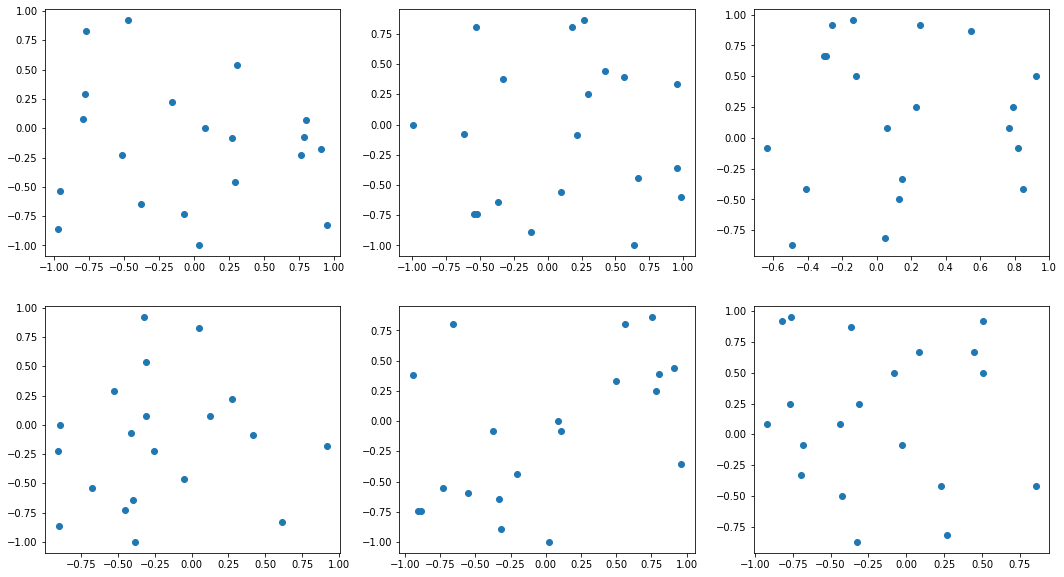

In [26]:
pl.figure(figsize=(18,10))

pl.subplot(2, 3, 1)

pl.plot(posC[:,0], BetterVec[:,0], marker='o', ls='')

pl.subplot(2, 3, 2)

pl.plot(posC[:,1], BetterVec[:,1], marker='o', ls='')

pl.subplot(2, 3, 3)

pl.plot(posC[:,2], BetterVec[:,2], marker='o', ls='')

pl.subplot(2, 3, 4)

pl.plot(velG[:,0], BetterVec[:,0], marker='o', ls='')

pl.subplot(2, 3, 5)

pl.plot(velG[:,1], BetterVec[:,1], marker='o', ls='')

pl.subplot(2, 3, 6)

pl.plot(velG[:,2], BetterVec[:,2], marker='o', ls='')

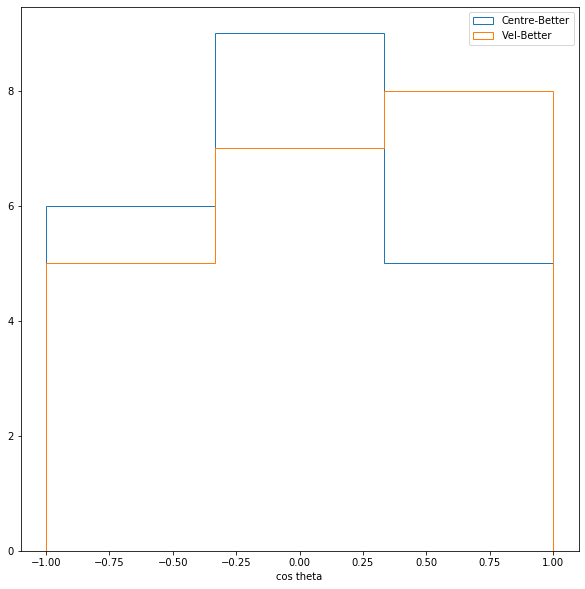

In [27]:
pl.figure(figsize=(10,10))

pl.hist(CosBV_C, range=(-1,1), bins=3, label='Centre-Better', histtype='step')
pl.hist(CosBV_V, range=(-1,1), bins=3, label='Vel-Better', histtype='step')

pl.xlabel('cos theta')
pl.legend(loc='best')